# Dogs v/s Cats Redux
### This notebook is for classification of photos into dogs and cats

Below are the python packages needed. As 2 convolutional layers did really bad, let's see whats the impact of adding more layers to it. Let's make it 6.

In [27]:
import os
import cv2
import numpy as np
import random
from tqdm import tqdm

TRAIN_DIR = "../input/train"
TEST_DIR = "../input/test"
IMG_SIZE = 50
LR = 1e-3

MODEL_NAME = "dogsvscats-{}-{}.model".format(LR, "6conv-basic")

I've taken one-hot classification labels based on closeness to the features of cat or dog. That means a vector of 2 dimensions `[x, y]`, where `x` is how close to be a cat in that photo and `y` is how close to be a dog it is. So, for to be classified as cat `[1, 0]` and to be dog `[0, 1]`

In [28]:
def label_img(img):
    word_label = img.split(".")[0]
    if word_label == "cat":
        return [1, 0]
    elif word_label == "dog":
        return [0, 1]

Let's create training data.

In [29]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR, img)
        img_resized = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        training_data.append([np.array(img_resized), np.array(label)])
    random.shuffle(training_data)
    np.save("training_data.npy", training_data)
    return training_data

Then let's process test data.

In [30]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR, img)
        img_num = img.split(".")[0]
        img_resized = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        testing_data.append([np.array(img_resized), img_num])
    np.save("testing_data.npy", testing_data)
    return testing_data

If we saved already, we can just load from the saved numpy file.

In [31]:
# train_data = create_train_data()
train_data = np.load("training_data.npy")

Now, I've defined a convolutional network model created in tflearn, with tensorflow backend framework. 

**Two convolutional layers with ReLU activation, optimized by AdamOptimizer,  Categorical Cross-entropy loss function, and with the learnng rate of 0.001**

In [32]:
import tflearn
import tensorflow as tf
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

tf.reset_default_graph()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

Let's quickly check what we have saved. We can see metadata of our notebooks and also other saved files.

In [33]:
print(os.listdir("."))

['.ipynb_checkpoints', 'training_data.npy', 'log', '__notebook_source__.ipynb']


If we have already saved the model as checkpoint, then we can just simply load it up and keep working. 

In [34]:
if os.path.exists("{}.meta".format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print("Model loaded")

Let's split for validation stats.

In [35]:
train = train_data[:-500]
test = train_data[-500:]

In [36]:
X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE , 1)
y = [i[1] for i in train]
test_X = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE , 1)
test_y = [i[1] for i in test]
X.shape, test_X.shape

((24500, 50, 50, 1), (500, 50, 50, 1))

Now, let's fit the model and see our validation scores and accuracies w.r.t each epoch as well as overall.

In [37]:
model.fit({"input": X}, 
          {"targets": y}, 
          n_epoch = 5, 
          validation_set = ({"input": test_X}, {"targets": test_y}),
          snapshot_step = 500, 
          show_metric = True, 
          run_id = MODEL_NAME)

Training Step: 1914  | total loss: 0.53127 | time: 78.061s
| Adam | epoch: 005 | loss: 0.53127 - acc: 0.7368 -- iter: 24448/24500
Training Step: 1915  | total loss: 0.53398 | time: 79.262s
| Adam | epoch: 005 | loss: 0.53398 - acc: 0.7288 | val_loss: 0.57309 - val_acc: 0.6920 -- iter: 24500/24500
--


Resulting accuracy of ~ 73% by just adding few more convolutional layers. 

Let's predict for the actual testing data.

In [38]:
# testing_data = process_test_data()
# np.save("testing_data.npy", testing_data)
testing_data = np.load("testing_data.npy")

100%|██████████| 12500/12500 [00:22<00:00, 548.46it/s]


Let's visualize some of the test data for clarity.

12it [00:00, 24.09it/s]


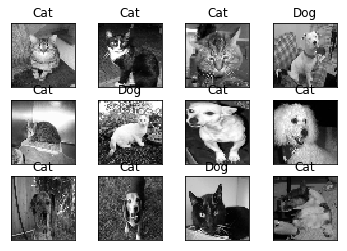

In [42]:
import matplotlib.pyplot as plt
fig = plt.figure()
for num, data in tqdm(enumerate(testing_data[:12])):
    # cat: [1,0]    dog: [0,1]
    img_num = data[1]
    img_data = data[0]
    y = fig.add_subplot(3,4, num+1)
    
    orig = img_data
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
    out = model.predict([data])[0]
    if np.argmax(out) == 1:
        res_label = "Cat"
    else:
        res_label = "Dog"
        
    y.imshow(orig, cmap="gray")
    plt.title(res_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()    

In [43]:
with open("submission_file.csv","w") as f:
    f.write("id,label\n")

In [44]:
with open("submission_file.csv","a") as f:
    for data in tqdm(testing_data):
        img_num = data[1]
        img_data = data[0]
        data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
        out = model.predict([data])[0]
        f.write("{},{}\n".format(img_num, out[1]))
        

100%|██████████| 12500/12500 [00:26<00:00, 467.40it/s]


In [47]:
import pandas as pd
sub = pd.read_csv("submission_file.csv")
print(sub.describe())
sub.head()

                 id         label
count  12500.000000  12500.000000
mean    6250.500000      0.589245
std     3608.583517      0.238303
min        1.000000      0.010511
25%     3125.750000      0.401939
50%     6250.500000      0.590950
75%     9375.250000      0.787371
max    12500.000000      0.998925


,id,label
0,3090,0.806140
1,8785,0.514174
2,10679,0.583544
3,7247,0.499805
4,8151,0.567702
